In [2]:
%load_ext autoreload
%autoreload 2

from run_models import load_model
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorKM
from Experiments import Experiment
from plot_experiments import *

device = 'cmod'
#dataset_path = 'random_256_shots_60%_flattop'
dataset_path = 'random_2000_shots_50%_flattop'

# Load models and create disruption predictors

cph_model, cph_transformer, cph_features = load_model('cph', device, dataset_path)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, cph_features, cph_transformer)

dcph_model, dcph_transformer, dcph_features = load_model('dcph', device, dataset_path)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, dcph_features, dcph_transformer)

dcm_model, dcm_transformer, dcm_features = load_model('dcm', device, dataset_path)
dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, dcm_features, dcm_transformer)

dsm_model, dsm_transformer, dsm_features = load_model('dsm', device, dataset_path)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, dsm_features, dsm_transformer)

#rsf_model, rsf_transformer, rsf_features = load_model('rsf', device, dataset)
#rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, rsf_features, rsf_transformer)

dprf_model, dprf_transformer, dprf_features = load_model('dprf', device, dataset_path)
dprf_predictor = DisruptionPredictorRF("Random Forest", dprf_model, dprf_features, dprf_transformer)

km_model, km_transformer, km_features = load_model('dprf', device, dataset_path)
km_predictor = DisruptionPredictorKM("Kaplan-Meier", km_model, km_features, km_transformer)

# Create experiments for each predictor
cph_experiment = Experiment(device, dataset_path, cph_predictor, 'CPH')
dcph_experiment = Experiment(device, dataset_path, dcph_predictor, 'DCPH')
dcm_experiment = Experiment(device, dataset_path, dcm_predictor, 'DCM')
dsm_experiment = Experiment(device, dataset_path, dsm_predictor, 'DSM')
#rsf_experiment = Experiment(device, test_dataset, rsf_predictor, 'RSF')
dprf_experiment = Experiment(device, dataset_path, dprf_predictor, 'DPRF')
km_experiment = Experiment(device, dataset_path, km_predictor, 'KM')


Loaded model from models/cmod/random_2000_shots_50%_flattop/cph.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dcph.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dcm.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dsm.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dprf.pkl
Loaded model from models/cmod/random_2000_shots_50%_flattop/dprf.pkl


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disr

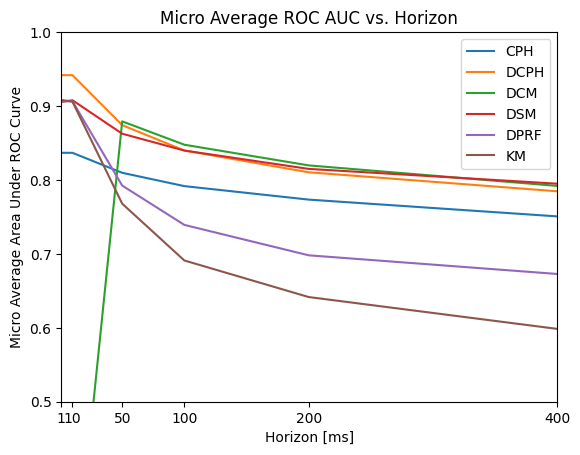

In [4]:
# Run the experiments
core_experiment_list = [cph_experiment, dcph_experiment, dcm_experiment, dsm_experiment, dprf_experiment, km_experiment]

plot_roc_auc_vs_horizon_micro(core_experiment_list)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disr

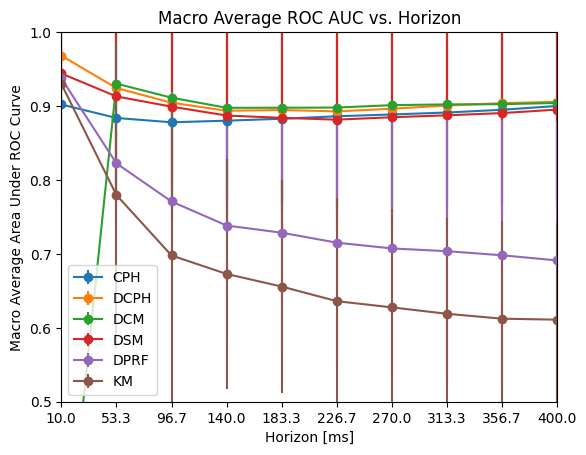

In [ ]:
plot_roc_auc_vs_horizon_macro(core_experiment_list)


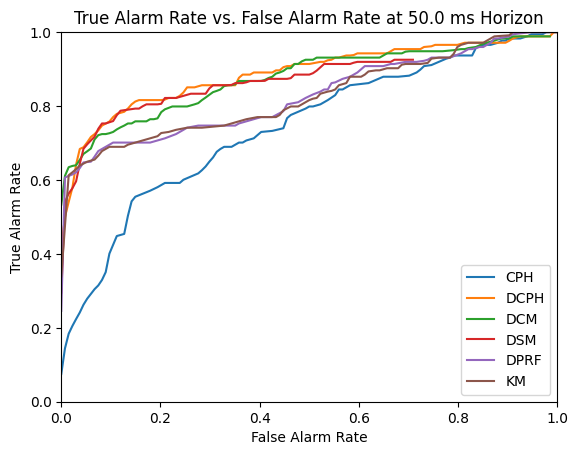

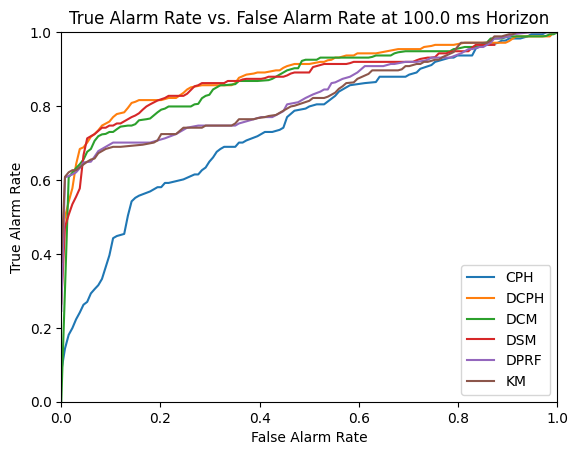

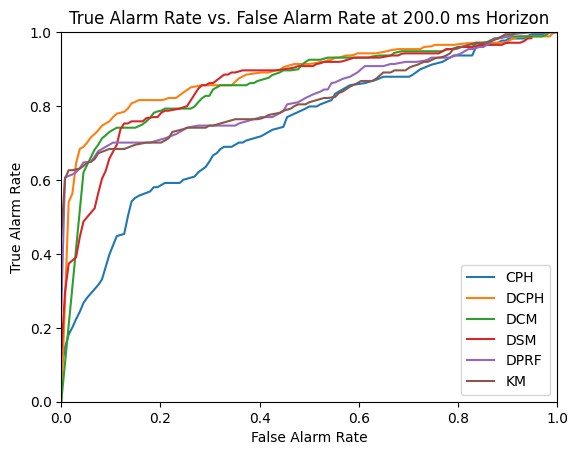

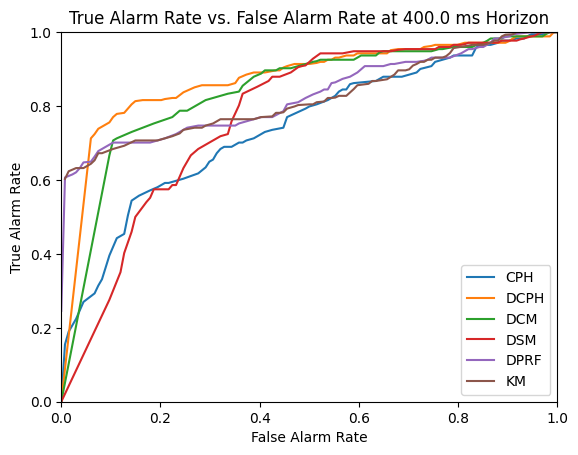

In [10]:
plot_TAR_vs_FAR(core_experiment_list, horizon=0.05)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.1)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.2)
plot_TAR_vs_FAR(core_experiment_list, horizon=0.4)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\sksurv\linear_model\coxph.py:127: RuntimeWarning: overflow encountered in power
  y=np.power(self.baseline_survival_.y, risk_score[i]))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disr

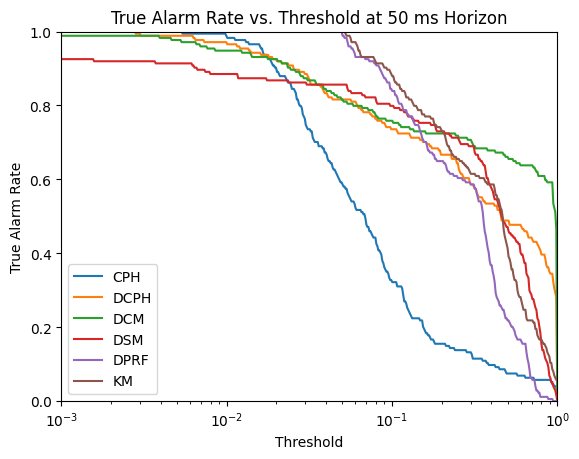

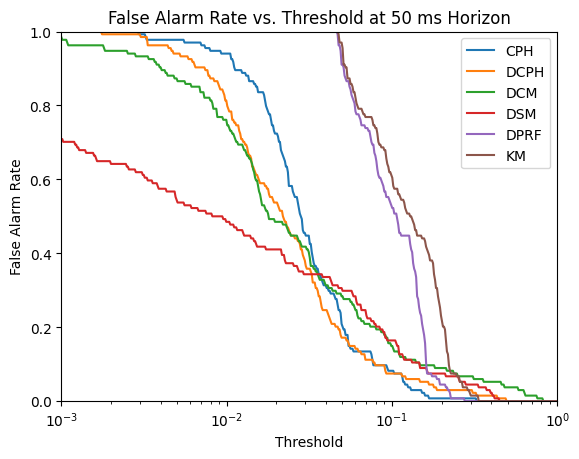

In [ ]:
plot_TAR_vs_threshold(core_experiment_list, horizon=0.05)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.05)

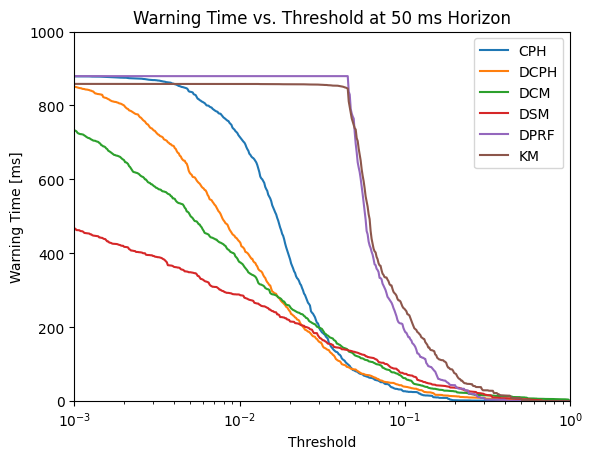

In [ ]:
plot_warning_time_vs_threshold(core_experiment_list, 0.05)


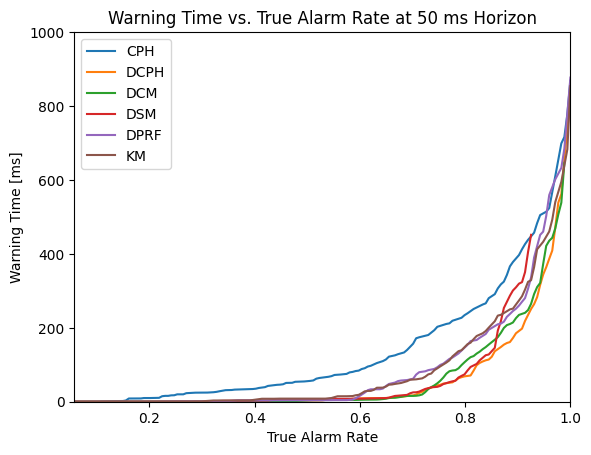

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:181: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min(false_alarm_rates), max(false_alarm_rates)])


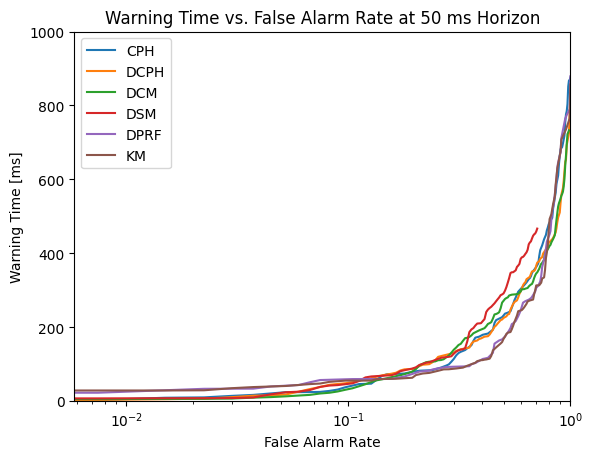

In [ ]:
plot_warning_time_vs_TAR(core_experiment_list, 0.05)
plot_warning_time_vs_FAR(core_experiment_list, 0.05)


c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:330: RuntimeWarning: invalid value encountered in divide
  threshold_precisions = np.sum(true_alarms, axis=0) / (np.sum(true_alarms, axis=0) + np.sum(false_alarms, axis=0))


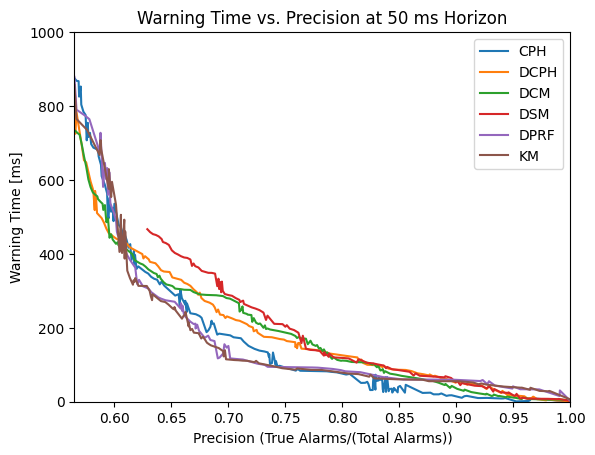

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:330: RuntimeWarning: invalid value encountered in divide
  threshold_precisions = np.sum(true_alarms, axis=0) / (np.sum(true_alarms, axis=0) + np.sum(false_alarms, axis=0))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\di

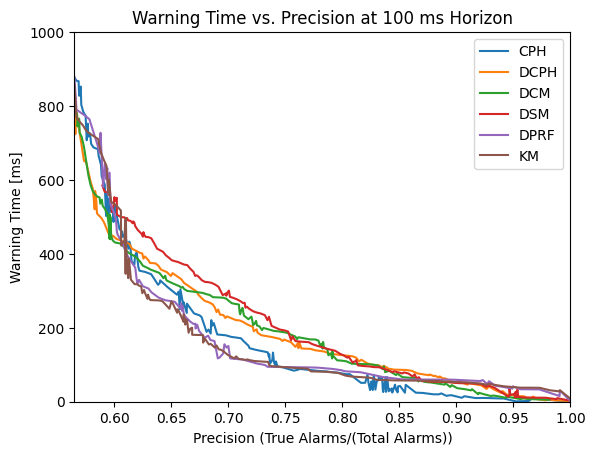

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:330: RuntimeWarning: invalid value encountered in divide
  threshold_precisions = np.sum(true_alarms, axis=0) / (np.sum(true_alarms, axis=0) + np.sum(false_alarms, axis=0))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\di

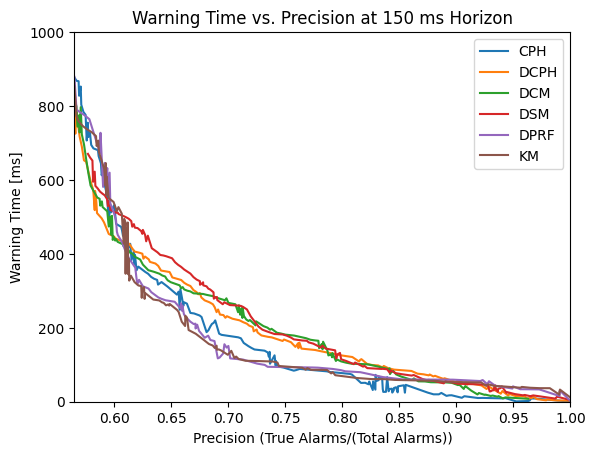

In [ ]:
plot_warning_time_vs_precision(core_experiment_list, 0.05)
plot_warning_time_vs_precision(core_experiment_list, 0.1)
plot_warning_time_vs_precision(core_experiment_list, 0.15)
